# Language-Visual Saliency with CLIP and OpenVINO™

The notebook will cover the following topics:

* Explanation of a _saliency map_ and how it can be used.
* Overview of the CLIP neural network and its usage in generating saliency maps.
* How to split a neural network into parts for separate inference.
* How to speed up inference with OpenVINO™ and asynchronous execution.

## Saliency Map

A saliency map is a visualization technique that highlights regions of interest in an image. For example, it can be used to [explain image classification predictions](https://academic.oup.com/mnras/article/511/4/5032/6529251#389668570) for a particular label. Here is an example of a saliency map that you will get in this notebook:

![](https://user-images.githubusercontent.com/29454499/218967961-9858efd5-fff2-4eb0-bde9-60852f4b31cb.JPG)

## CLIP

### What Is CLIP?

CLIP (Contrastive Language–Image Pre-training) is a neural network that can work with both images and texts. It has been trained to predict which randomly sampled text snippets are close to a given image, meaning that a text better describes the image. Here is a visualization of the pre-training process:

![](https://openaiassets.blob.core.windows.net/$web/clip/draft/20210104b/overview-a.svg)
[image_source](https://openai.com/blog/clip/)

To solve the task, CLIP uses two parts: `Image Encoder` and `Text Encoder`. Both parts are used to produce embeddings, which are vectors of floating-point numbers, for images and texts, respectively. Given two vectors, one can define and measure the similarity between them. A popular method to do so is the `cosine_similarity`, which is defined as the dot product of the two vectors divided by the product of their norms:

![cs](https://user-images.githubusercontent.com/29454499/218972165-f61a82f2-9711-4ce6-84b5-58fdd1d80d10.png)

The result can range from $-1$ to $1$. A value $1$ means that the vectors are similar, $0$ means that the vectors are not "connected" at all, and $-1$ is for vectors with somehow opposite "meaning". To train CLIP, OpenAI uses samples of texts and images and organizes them so that the first text corresponds to the first image in the batch, the second text to the second image, and so on. Then, cosine similarities are measured between all texts and all images, and the results are put in a matrix. If the matrix has numbers close to $1$ on a diagonal and close to $0$ elsewhere, it indicates that the network is appropriately trained.

### How to Build a Saliency Map with CLIP?

Providing an image and a text to CLIP returns two vectors. The cosine similarity between these vectors is calculated, resulting in a number between $-1$ and $1$ that indicates whether the text describes the image or not.
The idea is that _some regions of the image are closer to the text query_ than others, and this difference can be used to build the saliency map. Here is how it can be done:

1. Compute `query` and `image` similarity. This will represent the _neutral value_ $s_0$ on the `saliency map`.
2. Get a random `crop` of the image.
3. Compute `crop` and `query` similarity.
4. Subtract the $s_0$ from it. If the value is positive, the `crop` is closer to the `query`, and it should be a red region on the saliency map. If negative, it should be blue.
5. Update the corresponding region on the `saliency map`.
6. Repeat steps 2-5 multiple times (`n_iters`).

## Initial Implementation with Transformers and Pytorch

In [1]:
# Install requirements
!pip install -q 'openvino-dev>=2023.0.0'
!pip install -q onnx transformers torch gradio

In [2]:
from pathlib import Path
from typing import Tuple, Union, Optional
from urllib.request import urlretrieve

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

To get the CLIP model, you will use the `transformers` library and the official `openai/clip-vit-base-patch16` from OpenAI. You can use any CLIP model from the Huggingface Hub by simply replacing a model checkpoint in the cell below.

There are several preprocessing steps required to get text and image data to the model. Images have to be resized, cropped, and normalized, and text must be split into tokens and swapped by token IDs. To do that, you will use `CLIPProcessor`, which encapsulates all the preprocessing steps.

In [3]:
model_checkpoint = "openai/clip-vit-base-patch16"

model = CLIPModel.from_pretrained(model_checkpoint).eval()
processor = CLIPProcessor.from_pretrained(model_checkpoint)

2023-06-25 16:48:37.611708: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 16:48:37.613224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 16:48:37.642115: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 16:48:37.642840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 16:48:38.206050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Let us write helper functions first. You will generate crop coordinates and size with `get_random_crop_params`, and get the actual crop with `get_crop_image`. To update the saliency map with the calculated similarity, you will use `update_saliency_map`. A `cosine_similarity` function is just a code representation of the formula above.

In [4]:
def get_random_crop_params(
    image_height: int, image_width: int, min_crop_size: int
) -> Tuple[int, int, int, int]:
    crop_size = np.random.randint(min_crop_size, min(image_height, image_width))
    x = np.random.randint(image_width - crop_size + 1)
    y = np.random.randint(image_height - crop_size + 1)
    return x, y, crop_size


def get_cropped_image(
    im_tensor: np.array, x: int, y: int, crop_size: int
) -> np.array:
    return im_tensor[
        y : y + crop_size,
        x : x + crop_size,
        ...
    ]


def update_saliency_map(
    saliency_map: np.array, similarity: float, x: int, y: int, crop_size: int
) -> None:
    saliency_map[
        y : y + crop_size,
        x : x + crop_size,
    ] += similarity


def cosine_similarity(
    one: Union[np.ndarray, torch.Tensor], other: Union[np.ndarray, torch.Tensor]
) -> Union[np.ndarray, torch.Tensor]:
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))

Parameters to be defined:
- `n_iters` - number of times the procedure will be repeated. Larger is better, but will require more time to inference
- `min_crop_size` - minimum size of the crop window. A smaller size will increase the resolution of the saliency map but may require more iterations
- `query` - text that will be used to query the image
- `image` - the actual image that will be queried. You will download the image from a link

The image at the beginning was acquired with `n_iters=2000` and `min_crop_size=50`. You will start with the lower number of inferences to get the result faster. It is recommended to experiment with the parameters at the end, when you get an optimized model.

In [5]:
n_iters = 300
min_crop_size = 50

query = "Who developed the Theory of General Relativity?"
image_path = Path("example.jpg")
urlretrieve("https://pbs.twimg.com/media/Ee_aDODUMAAEBjW?format=jpg&name=small", image_path)
image = Image.open(image_path)
im_tensor = np.array(image)

x_dim, y_dim = image.size

Given the `model` and `processor`, the actual inference is simple: transform the text and image into combined `inputs` and pass it to the model:

In [6]:
inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")
with torch.no_grad():
    results = model(**inputs)
results.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

The model produces several outputs, but for your application, you are interested in `text_embeds` and `image_embeds`, which are the vectors for text and image, respectively. Now, you can calculate `initial_similarity` between the `query` and the `image`. You also initialize a saliency map. Numbers in the comments correspond to the items in the "How To Build a Saliency Map With CLIP?" list above.

In [7]:
initial_similarity = cosine_similarity(results.text_embeds, results.image_embeds).item()  # 1. Computing query and image similarity
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):  # 6. Setting number of the procedure iterations 
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)  # 2. Getting a random crop of the image

    inputs = processor(text=[query], images=[im_crop], return_tensors="pt")
    with torch.no_grad():
        results = model(**inputs)  # 3. Computing crop and query similarity

    similarity = cosine_similarity(results.text_embeds, results.image_embeds).item() - initial_similarity  # 4. Subtracting query and image similarity from crop and query similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)  # 5. Updating the region on the saliency map

  0%|          | 0/300 [00:00<?, ?it/s]

To visualize the resulting saliency map, you can use `matplotlib`:

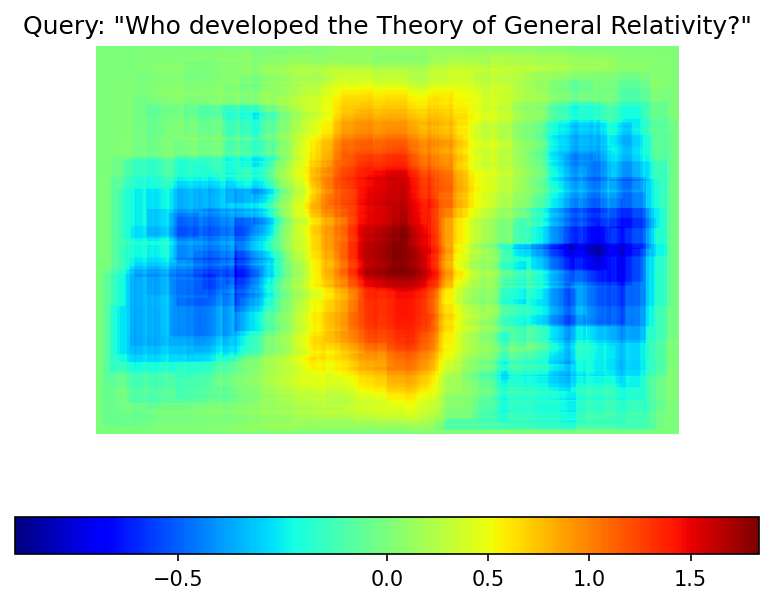

In [8]:
plt.figure(dpi=150)
plt.imshow(saliency_map, norm=colors.TwoSlopeNorm(vcenter=0), cmap='jet')
plt.colorbar(location="bottom")
plt.title(f'Query: \"{query}\"')
plt.axis("off")
plt.show()

The result map is not as smooth as in the example picture because of the lower number of iterations. However, the same red and blue areas are clearly visible.

Let us overlay the saliency map on the image:

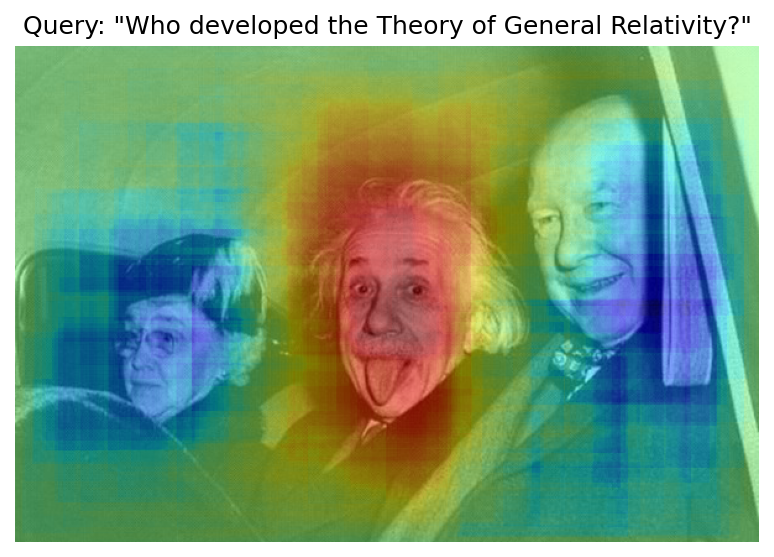

In [9]:
def plot_saliency_map(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]) -> None:
    fig = plt.figure(dpi=150)
    plt.imshow(image_tensor)
    plt.imshow(
        saliency_map, 
        norm=colors.TwoSlopeNorm(vcenter=0), 
        cmap="jet", 
        alpha=0.5,  # make saliency map trasparent to see original picture
    )
    if query:
        plt.title(f'Query: "{query}"')
    plt.axis("off")
    return fig
    


plot_saliency_map(im_tensor, saliency_map, query);

## Separate Text and Visual Processing

The code above is functional, but there are some repeated computations that can be avoided. The text embedding can be computed once because it does not depend on the input image. This separation will also be useful in the future. The initial preparation will remain the same since you still need to compute the similarity between the text and the full image. After that, the `get_image_features` method could be used to obtain embeddings for the cropped images.

  0%|          | 0/300 [00:00<?, ?it/s]

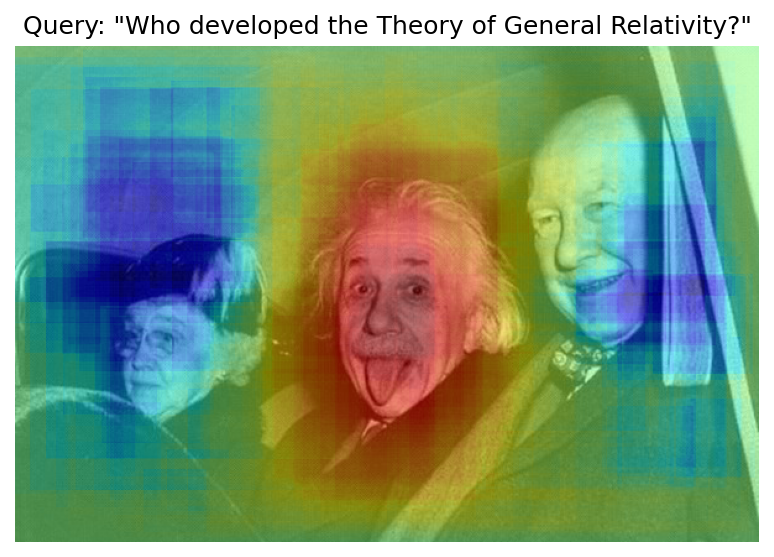

In [10]:
inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")
with torch.no_grad():
    results = model(**inputs)
text_embeds = results.text_embeds  # save text embeddings to use them later

initial_similarity = cosine_similarity(text_embeds, results.image_embeds).item()
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)

    image_inputs = processor(images=[im_crop], return_tensors="pt")  # crop preprocessing
    with torch.no_grad():
        image_embeds = model.get_image_features(**image_inputs)  # calculate image embeddings only

    similarity = cosine_similarity(text_embeds, image_embeds).item() - initial_similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)

plot_saliency_map(im_tensor, saliency_map, query);

The result might be slightly different because you use random crops to build a saliency map.

## Convert to OpenVINO™ Intermediate Representation (IR) Format

The process of building a saliency map can be quite time-consuming. To speed it up, you will use OpenVINO. OpenVINO is an inference framework designed to run pre-trained neural networks efficiently. One way to use it is to convert a model from its original framework representation to an OpenVINO Intermediate Representation (IR) format and then load it for inference. The model currently uses PyTorch. To get an IR, you need to first convert the PyTorch model to the ONNX format. It can be done with the `torch.onnx.export` function. See the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html) for more information on ONNX conversion.

In [11]:
model_name = model_checkpoint.split('/')[-1]

onnx_model_path = Path("onnx") / f"{model_name}.onnx"
onnx_model_path.parent.mkdir(exist_ok=True)

torch.onnx.export(
    model,  # model is being run
    dict(inputs),
    onnx_model_path,  # where to save the model
    opset_version=14,  # the ONNX version to export the model to
    input_names=["input_ids", "pixel_values", "attention_mask"],  # the model's input names
    output_names=["logits_per_image", "logits_per_text", "text_embeds", "image_embeds"],  # the model's output names
    dynamic_axes={  # variable length axes
        "input_ids": {0: "batch", 1: "sequence"},
        "pixel_values": {0: "batch", 1: "num_channels", 2: "height", 3: "width"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits_per_image": {0: "batch"},
        "logits_per_text": {0: "batch"},
        "text_embeds": {0: "batch"},
        "image_embeds": {0: "batch"}
    }
)

/home/dm/code/openvino_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:284: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/dm/code/openvino_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:324: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
/home/dm/code/openvino_env/lib/python3.8/site-packages/transformers/models/clip/modeling_clip.py:292: TracerWarning: Conv

Currently, you can load an ONNX file to OpenVINO and serialize the resulting model into an IR. This may not be optimal for your use case. The CLIP model contains two separate parts: the image encoder and the text encoder. You can split the CLIP into two models and call them separately.

To convert the model to IR, you can use [Model Optimizer (MO)](https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). When you convert a model to the OpenVINO format, Model Optimizer enables specifying the inputs and outputs you want to use. During the conversion, it will trim the remaining parts of the model. Therefore, when you pass the text inputs and outputs, the MO will "extract" only the text part of the model.

You already know the required outputs: `text_embeds` and `image_embeds`. The input for the image is `pixel_values`, and the remaining `input_ids` and `attention_mask` correspond to the text. You also make the image input of the model static because there is no variation in the input size after preprocessing.

In [12]:
from openvino.runtime import serialize
from openvino.tools import mo


text_ov_model = mo.convert_model(
    onnx_model_path, 
    compress_to_fp16=True,
    input="input_ids,attention_mask",
    output="text_embeds",
)

# get image size after preprocessing from the processor
crops_info = processor.image_processor.crop_size.values() if hasattr(processor, "image_processor") else processor.feature_extractor.crop_size.values()
processed_image_height_width = ",".join(map(str, crops_info))
image_ov_model = mo.convert_model(
    onnx_model_path, 
    compress_to_fp16=True,
    input="pixel_values",
    input_shape=f"[1,3,{processed_image_height_width}]",
    output="image_embeds",
)

ov_dir = Path("ir")
ov_dir.mkdir(exist_ok=True)
text_model_path = ov_dir / f"{model_name}_text.xml"
image_model_path = ov_dir / f"{model_name}_image.xml"

# write resulting models on disk
serialize(text_ov_model, str(text_model_path))
serialize(image_ov_model, str(image_model_path))

Now, you have two separate models for text and images, stored on disk and ready to be loaded and inferred with OpenVINO™.

## Inference with OpenVINO™

1. Create an instance of the `Core` object that will handle any interaction with OpenVINO runtime for you.
1. Use the `core.read_model` method to load the model into memory.
1. Compile the model with the `core.compile_model` method for a particular device to apply device-specific optimizations.
1. Use the compiled model for inference.

In [13]:
from openvino.runtime import Core


core = Core()

text_model = core.read_model(text_model_path)
image_model = core.read_model(image_model_path)

text_model = core.compile_model(model=text_model, device_name="CPU")
image_model = core.compile_model(model=image_model, device_name="CPU")

OpenVINO supports `numpy.ndarray` as an input type, so you change the `return_tensors` to `np`. You also convert a transformers' `BatchEncoding` object to a python dictionary with input names as keys and input tensors for values.

Once you have a compiled model, the inference is similar to Pytorch - a compiled model is callable. Just pass input data to it. Inference results are stored in the dictionary. Once you have a compiled model, the inference process is mostly similar.

  0%|          | 0/300 [00:00<?, ?it/s]

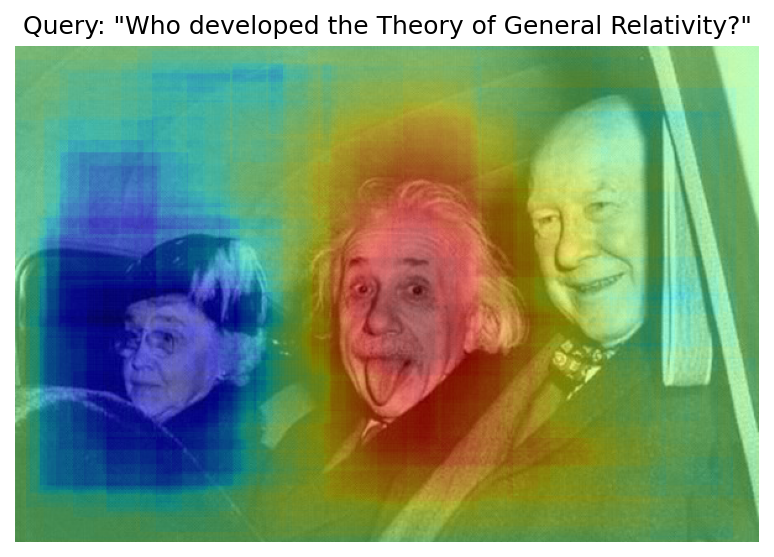

In [14]:
text_inputs = dict(
    processor(text=[query], images=[im_tensor], return_tensors="np")
)
image_inputs = text_inputs.pop("pixel_values")

text_embeds = text_model(text_inputs)[text_model.output()]
image_embeds = image_model(image_inputs)[image_model.output()]

initial_similarity = cosine_similarity(text_embeds, image_embeds)
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(range(n_iters)):
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(im_tensor, x, y, crop_size)

    image_inputs = processor(images=[im_crop], return_tensors="np").pixel_values
    image_embeds = image_model(image_inputs)[image_model.output()]

    similarity = cosine_similarity(text_embeds, image_embeds) - initial_similarity
    update_saliency_map(saliency_map, similarity, x, y, crop_size)

plot_saliency_map(im_tensor, saliency_map, query);

## Accelerate Inference with AsyncInferQueue

Up until now, the pipeline was synchronous, which means that the data preparation, model input population, model inference, and output processing is sequential. That is a simple, but not the most effective way to organize an inference pipeline in your case. To utilize the available resources more efficiently, you will use `AsyncInferQueue`. It can be instantiated with compiled model and a number of jobs - parallel execution threads. If you do not pass a number of jobs or pass `0`, then OpenVINO will pick the optimal number based on your device and heuristics. After acquiring the inference queue, you have two jobs to do:

- Preprocess the data and push it to the inference queue. The preprocessing steps will remain the same
- Tell the inference queue what to do with the model output after the inference is finished. It is represented by a python function called `callback` that takes an inference result and data that you passed to the inference queue along with the prepared input data

Everything else will be handled by the `AsyncInferQueue` instance.

There is another low-hanging bit of optimization. You are expecting many inference requests for your image model at once and want the model to process them as fast as possible. In other words - maximize the **throughput**. To do that, you can recompile the model giving it the performance hint.

In [15]:
from typing import Dict, Any
from openvino.runtime import AsyncInferQueue, InferRequest


image_model = core.read_model(image_model_path)

image_model = core.compile_model(
    model=image_model, 
    device_name="CPU", 
    config={"PERFORMANCE_HINT":"THROUGHPUT"},
)

In [16]:
text_inputs = dict(
    processor(text=[query], images=[im_tensor], return_tensors="np")
)
image_inputs = text_inputs.pop("pixel_values")

text_embeds = text_model(text_inputs)[text_model.output()]
image_embeds = image_model(image_inputs)[image_model.output()]

initial_similarity = cosine_similarity(text_embeds, image_embeds)
saliency_map = np.zeros((y_dim, x_dim))

Your callback should do the same thing that you did after inference in the sync mode:
- Pull the image embeddings from an inference request.
- Compute cosine similarity between text and image embeddings.
- Update saliency map based.

If you do not change the progress bar, it will show the progress of pushing data to the inference queue. To track the actual progress, you should pass a progress bar object and call `update` method after `update_saliency_map` call.

In [17]:
def completion_callback(
    infer_request: InferRequest,  # inferente result
    user_data: Dict[str, Any],  # data that you passed along with input pixel values
) -> None:
    pbar = user_data.pop("pbar")
    
    image_embeds = infer_request.get_output_tensor().data
    similarity = (
        cosine_similarity(user_data.pop("text_embeds"), image_embeds) - user_data.pop("initial_similarity")
    )
    update_saliency_map(**user_data, similarity=similarity)
    
    pbar.update(1)  # update the progress bar


infer_queue = AsyncInferQueue(image_model)
infer_queue.set_callback(completion_callback)

  0%|          | 0/300 [00:00<?, ?it/s]

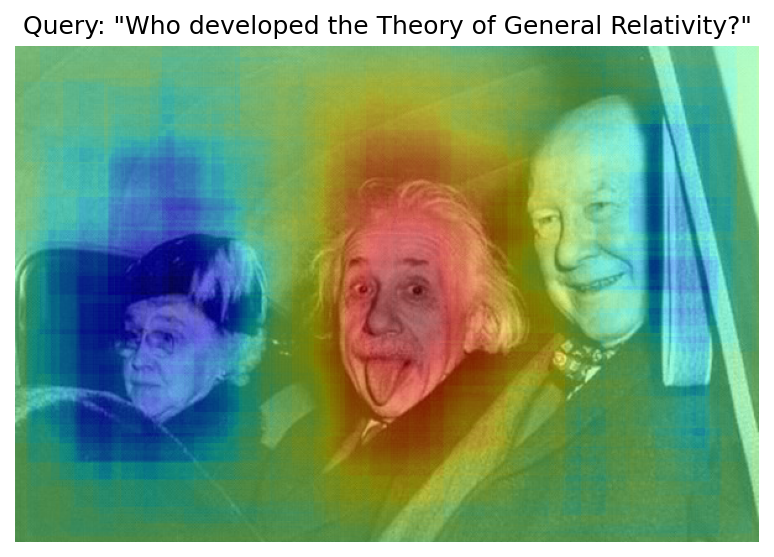

In [18]:
def infer(im_tensor, x_dim, y_dim, text_embeds, image_embeds, initial_similarity, saliency_map, query, n_iters, min_crop_size, _tqdm=tqdm.notebook.tqdm, include_query=True):
    with _tqdm(total=n_iters) as pbar:
        for _ in range(n_iters):    
            x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
            im_crop = get_cropped_image(im_tensor, x, y, crop_size)
    
            image_inputs = processor(images=[im_crop], return_tensors="np")
            
            # push data to the queue
            infer_queue.start_async(
                # pass inference data as usual
                image_inputs.pixel_values,
                # the data that will be passed to the callback after the inference complete
                {
                    "text_embeds": text_embeds, 
                    "saliency_map": saliency_map,
                    "initial_similarity": initial_similarity,
                    "x": x, 
                    "y": y, 
                    "crop_size": crop_size,
                    "pbar": pbar,
                }
            )
        
        # after you pushed all data to the queue you wait until all callbacks finished
        infer_queue.wait_all()
    
    return plot_saliency_map(im_tensor, saliency_map, query if include_query else None)
infer(im_tensor, x_dim, y_dim, text_embeds, image_embeds, initial_similarity, saliency_map, query, n_iters, min_crop_size, _tqdm=tqdm.notebook.tqdm, include_query=True);

## Pack the Pipeline into a Function

Let us wrap all code in the function and add a user interface to it.

In [19]:
import ipywidgets as widgets


def build_saliency_map(image: Image, query: str, n_iters: int = n_iters, min_crop_size=min_crop_size, _tqdm=tqdm.notebook.tqdm, include_query=True):
    x_dim, y_dim = image.size
    im_tensor = np.array(image)

    text_inputs = dict(
        processor(text=[query], images=[im_tensor], return_tensors="np")
    )
    image_inputs = text_inputs.pop("pixel_values")

    text_embeds = text_model(text_inputs)[text_model.output()]
    image_embeds = image_model(image_inputs)[image_model.output()]

    initial_similarity = cosine_similarity(text_embeds, image_embeds)
    saliency_map = np.zeros((y_dim, x_dim))

    return infer(im_tensor, x_dim, y_dim, text_embeds, image_embeds, initial_similarity, saliency_map, query, n_iters, min_crop_size, _tqdm=_tqdm, include_query=include_query)

The first version will enable passing a link to the image, as you have done so far in the notebook.

In [20]:
n_iters_widget = widgets.BoundedIntText(
    value=n_iters,
    min=1,
    max=10000,
    description="n_iters",
)
min_crop_size_widget = widgets.IntSlider(
    value=min_crop_size,
    min=1,
    max=200,
    description="min_crop_size",
)


@widgets.interact_manual(image_link="", query="", n_iters=n_iters_widget, min_crop_size=min_crop_size_widget)
def build_saliency_map_from_image_link(
    image_link: str,
    query: str,
    n_iters: int,
    min_crop_size: int,
) -> None:
    try:
        image_bytes = requests.get(image_link, stream=True).raw
    except requests.RequestException as e:
        print(f"Cannot load image from link: {image_link}\nException: {e}")
        return
    
    image = Image.open(image_bytes)
    image = image.convert("RGB")  # remove transparency channel or convert grayscale 1 channel to 3 channels
    
    build_saliency_map(image, query, n_iters, min_crop_size)

interactive(children=(Text(value='', continuous_update=False, description='image_link'), Text(value='', contin…

The second version will enable loading the image from your computer.

In [21]:
import io


load_file_widget = widgets.FileUpload(
    accept="image/*", multiple=False, description="Image file",
)


@widgets.interact_manual(file=load_file_widget, query="", n_iters=n_iters_widget, min_crop_size=min_crop_size_widget)
def build_saliency_map_from_file(
    file: Path,
    query: str = "",
    n_iters: int = 2000,
    min_crop_size: int = 50,
) -> None:
    image_bytes = io.BytesIO(file[0]["content"])
    try:
        image = Image.open(image_bytes)
    except Exception as e:
        print(f"Cannot load the image: {e}")
        return
    
    image = image.convert("RGB")
    
    build_saliency_map(image, query, n_iters, min_crop_size)

interactive(children=(FileUpload(value=(), accept='image/*', description='Image file'), Text(value='', continu…

## Interactive demo with Gradio

In [ ]:
import gradio as gr


def _process(image, query, n_iters, min_crop_size, _=gr.Progress(track_tqdm=True)):
    saliency_map = build_saliency_map(image, query, n_iters, min_crop_size, _tqdm=tqdm.tqdm, include_query=False)

    return saliency_map


demo = gr.Interface(
    _process,
    [
        gr.Image(label="Image", type="pil"),
        gr.Textbox(label="Query"),
        gr.Slider(1, 10000, n_iters, label="Number of iterations"),
        gr.Slider(1, 200, min_crop_size, label="Minimum crop size"),
    ],
    gr.Plot(label="Result"),
    examples=[[image_path, query]],
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

## What To Do Next

Now that you have a convenient interface and accelerated inference, you can explore the CLIP capabilities further. For example:
- Can CLIP read? Can it detect text regions in general and specific words on the image?
- Which famous people and places does CLIP know?
- Can CLIP identify places on a map? Or planets, stars, and constellations?
- Explore different CLIP models from Huggingface Hub: just change the `model_checkpoint` at the beginning of the notebook.
- Add batch processing to the pipeline: modify `get_random_crop_params`, `get_cropped_image` and `update_saliency_map` functions to process multiple crop images at once and accelerate the pipeline even more.
- Optimize models with [NNCF](https://docs.openvino.ai/nightly/basic_quantization_flow.html) to get further acceleration.